# Getting Started Examples for the Parangonar Library

The following code loads the contents of a a previously aligned performance
and score alignment file (encoded in the [match file format](https://cpjku.github.io/matchfile/)). 

A new alignment is computed using different note matchers and the predicted alignment are compared to the ground truth:

### 1 - Automatic Note Matching: `AutomaticNoteMatcher` and `DualDTWNoteMatcher`

In [20]:
import os
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline
import parangonar as pa
import partitura as pt

In [21]:
perf_match, groundtruth_alignment, score_match = pt.load_match(
    filename= pa.EXAMPLE, # 
    create_score=True
)

# compute note arrays from the loaded score and performance
pna_match = perf_match[0].note_array()
sna_match = score_match[0].note_array()

# match the notes in the note arrays --------------------- AutomaticNoteMatcher
matcher = pa.AutomaticNoteMatcher()
pred_alignment = matcher(sna_match, 
                        pna_match,
                        verbose_time=True)

# compute f-score and print the results
print('------------------')
types = ['match','insertion', 'deletion']
for alignment_type in types:
    precision, recall, f_score = pa.fscore_alignments(pred_alignment, 
                                                      groundtruth_alignment, 
                                                      alignment_type)
    print('Evaluate ',alignment_type)
    print('Precision: ',format(precision, '.3f'),
          'Recall ',format(recall, '.3f'),
          'F-Score ',format(f_score, '.3f'))
    print('------------------')

0.346 sec : Initial coarse DTW pass
0.001 sec : Cutting
0.309 sec : Fine-grained DTW passes, symbolic matching
0.004 sec : Mending
------------------
Evaluate  match
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------
Evaluate  insertion
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------
Evaluate  deletion
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------


In [22]:
# compute note arrays from the loaded score and performance
pna_match = perf_match[0].note_array()
# this matcher requires grace note info
sna_match = score_match[0].note_array(include_grace_notes=True)

# match the notes in the note arrays --------------------- DualDTWNoteMatcher
matcher = pa.DualDTWNoteMatcher()
pred_alignment = matcher(sna_match, 
                        pna_match,
                        process_ornaments=False,
                        score_part=score_match[0]) # if a score part is passed, ornaments can be handled seperately

# compute f-score and print the results
print('------------------')
types = ['match','insertion', 'deletion']
for alignment_type in types:
    precision, recall, f_score = pa.fscore_alignments(pred_alignment, 
                                                      groundtruth_alignment, 
                                                      alignment_type)
    print('Evaluate ',alignment_type)
    print('Precision: ',format(precision, '.3f'),
          'Recall ',format(recall, '.3f'),
          'F-Score ',format(f_score, '.3f'))
    print('------------------')

------------------
Evaluate  match
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------
Evaluate  insertion
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------
Evaluate  deletion
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------


### 2 - Anchor Point Alignment: `AnchorPointNoteMatcher` 


In [23]:
# compute note arrays from the loaded score and performance
pna_match = perf_match[0].note_array()
sna_match = score_match[0].note_array()

# compute synthetic anchor points every 4 beats
nodes = pa.match.node_array(score_match[0], 
                   perf_match[0], 
                   groundtruth_alignment,
                   node_interval=4)

# match the notes in the note arrays
matcher = pa.AnchorPointNoteMatcher()
pred_alignment = matcher(sna_match, 
                        pna_match,
                        nodes)

# compute f-score and print the results
print('------------------')
types = ['match','insertion', 'deletion']
for alignment_type in types:
    precision, recall, f_score = pa.fscore_alignments(pred_alignment, 
                                                      groundtruth_alignment, 
                                                      alignment_type)
    print('Evaluate ',alignment_type)
    print('Precision: ',format(precision, '.3f'),
          'Recall ',format(recall, '.3f'),
          'F-Score ',format(f_score, '.3f'))
    print('------------------')

------------------
Evaluate  match
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------
Evaluate  insertion
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------
Evaluate  deletion
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------


### 3 - Online / Realtime Alignment: `OnlineTransformerMatcher` 


In [24]:
# compute note arrays from the loaded score and performance
pna_match = perf_match[0].note_array()
# this matcher requires grace note info
sna_match = score_match[0].note_array(include_grace_notes=True)

# set up the matcher using the score information: OnlineTransformerMatcher / OnlinePureTransformerMatcher
matcher = pa.OnlinePureTransformerMatcher(sna_match)

# the "offline" method loops over all notes in the performance and calls the "online" method for each one.
pred_alignment = matcher.offline(pna_match)

# compute f-score and print the results
print('------------------')
types = ['match','insertion', 'deletion']
for alignment_type in types:
    precision, recall, f_score = pa.fscore_alignments(pred_alignment, 
                                                      groundtruth_alignment, 
                                                      alignment_type)
    print('Evaluate ',alignment_type)
    print('Precision: ',format(precision, '.3f'),
          'Recall ',format(recall, '.3f'),
          'F-Score ',format(f_score, '.3f'))
    print('------------------')

------------------
Evaluate  match
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------
Evaluate  insertion
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------
Evaluate  deletion
Precision:  1.000 Recall  1.000 F-Score  1.000
------------------


### 4 - Visualize Alignment


In [25]:
# this matcher creates an error for the default file, so we can use for visualization
matcher = pa.OnlineTransformerMatcher(sna_match)
pred_alignment = matcher.offline(pna_match)

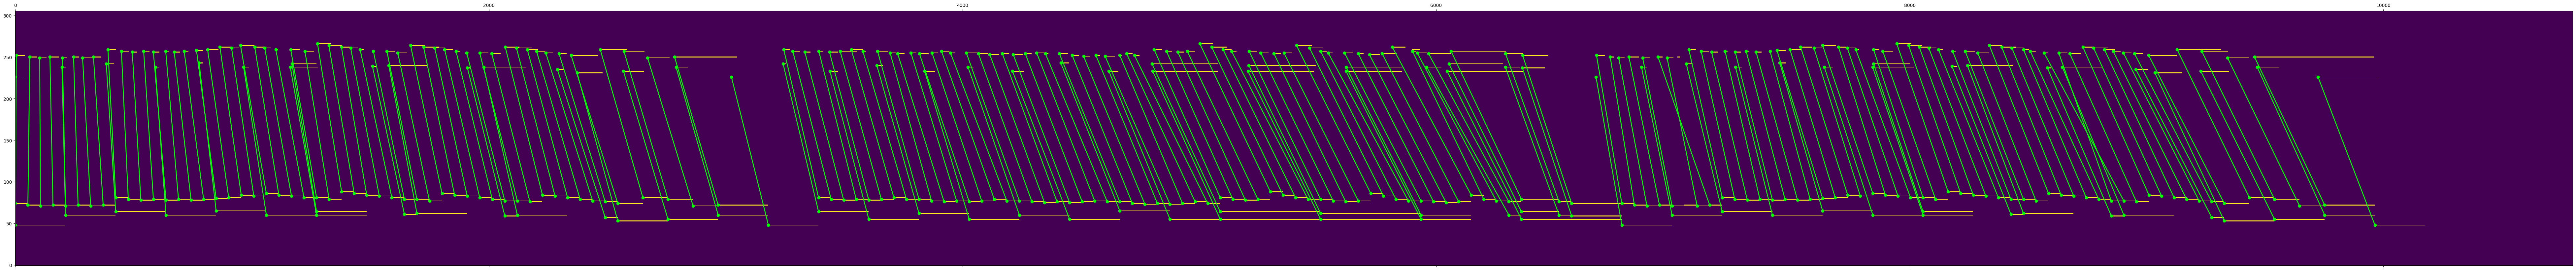

In [26]:
# show or save plot of note alignment
pa.plot_alignment(pna_match,
                sna_match,
                pred_alignment,
                save_file = False)


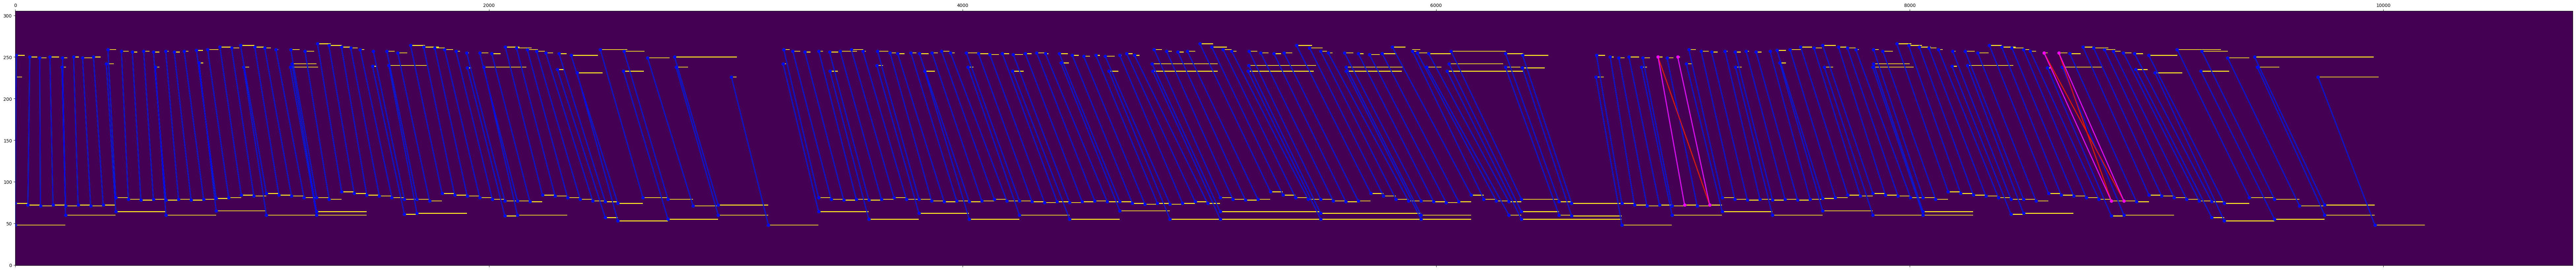

In [27]:
# or plot the performance and score as piano rolls given a reference: 
# we can encode errors if given ground truth
# Blue lines indicate correct matches, red lines incorrect ones.
pa.plot_alignment_comparison(pna_match, sna_match, 
                         pred_alignment, groundtruth_alignment)

### 5 - File I/O for note alignments

Most I/O functions are handled by partitura. 
For [Parangonada](https://sildater.github.io/parangonada/):
- pt.io.importparangonada.load_parangonada_alignment
- pt.io.importparangonada.load_parangonada_csv
- pt.io.exportparangonada.save_parangonada_alignment
- pt.io.exportparangonada.save_parangonada_csv

For [(n)ASAP alignments](https://github.com/CPJKU/asap-dataset)
- pt.io.importparangonada.load_alignment_from_ASAP
- pt.io.exportparangonada.save_alignment_for_ASAP

For [match files](https://cpjku.github.io/matchfile/)
- pt.io.importmatch.load_match
- pt.io.exportmatch.save_match

and a basic interface for saving parangonada-ready csv files is also available:

In [28]:
# export a note alignment for visualization with parangonada:
# https://sildater.github.io/parangonada/
# pa.match.save_parangonada_csv(alignment, performance_data, score_data, outdir="path/to/dir")

In [29]:
# import a corrected note alignment from parangonada:
# https://sildater.github.io/parangonada/
# alignment = pt.io.importparangonada.load_parangonada_alignment(filename= 'path/to/note_alignment.csv')

# load note alignments of the asap dataset: 
# https://github.com/CPJKU/asap-dataset
# alignment = pt.io.importparangonada.load_alignment_from_ASAP(filename= 'path/to/note_alignment.tsv')

### 6 - Aligned Data

These note-aligned datasets are publically available:
- [Vienna 4x22](https://github.com/CPJKU/vienna4x22)
- [(n)ASAP note alignments](https://github.com/CPJKU/asap-dataset)
- [Batik Dataset](https://github.com/huispaty/batik_plays_mozart)